In [57]:
%load_ext autoreload
%autoreload 2

import os, json
import nibabel as nb
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hrf_estimation
import scipy.signal as signal
import scipy.stats as stats

from joblib import Parallel, delayed
import copy
# import tensorflow as tf

%matplotlib inline

sns.set_context("notebook", font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# requires pfpy be installed - preferably with python setup.py develop
from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.grid import Iso2DGaussianGridder
from prfpy.fit import Iso2DGaussianFitter
import prfpy.cnn as cnn

Using TensorFlow backend.


In [6]:
stim_dm = np.load('../data/dm.npy').T # transpose for final dimension time
prf_stim = PRFStimulus2D(screen_size_cm=70, 
                         screen_distance_cm=125, 
                         design_matrix=stim_dm, 
                         TR=1.6)

grid_nr = 20
max_ecc_size = 16
sizes, eccs, polars = max_ecc_size * np.linspace(0.25,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.1,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr)

gg = Iso2DGaussianGridder(stimulus=prf_stim)
# gf = Iso2DGaussianFitter(data=, gridder=gg, n_jobs=-1, fit_css=True)

In [7]:
mask = nb.load('../data/sub-01_task-prf_dir-AP_cortical_mask.nii.gz').get_data().astype(bool)
timecoursefile = nb.load('../data/sub-01_task-prf_acq-median_masked_T1w_desc-preproc_bold.nii.gz')
timecourse = timecoursefile.get_data()

In [ ]:
%%time
gf = Iso2DGaussianFitter(data=timecourse[mask], gridder=gg, n_jobs=16, fit_css=True)
gf.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes,
                 n_grid=np.linspace(0.2,1,4))

  0%|          | 0/32000 [00:00<?, ?it/s]/home/knapen/projects/prfpy/prfpy/fit.py:170: RuntimeWarning: divide by zero encountered in true_divide
  rsqs = ((1 - residual / (self.n_timepoints * self.data_var)))
/home/knapen/projects/prfpy/prfpy/fit.py:170: RuntimeWarning: invalid value encountered in true_divide
  rsqs = ((1 - residual / (self.n_timepoints * self.data_var)))
/home/knapen/projects/prfpy/prfpy/fit.py:172: RuntimeWarning: invalid value encountered in greater
  improved_fits = rsqs > self.gridsearch_r2
 12%|█▏        | 3933/32000 [17:30<2:13:53,  3.49it/s]

In [38]:
%%time
gf.iterative_fit(rsq_threshold=0.6, verbose=False)

CPU times: user 26min 43s, sys: 1min 3s, total: 27min 46s
Wall time: 27min 51s


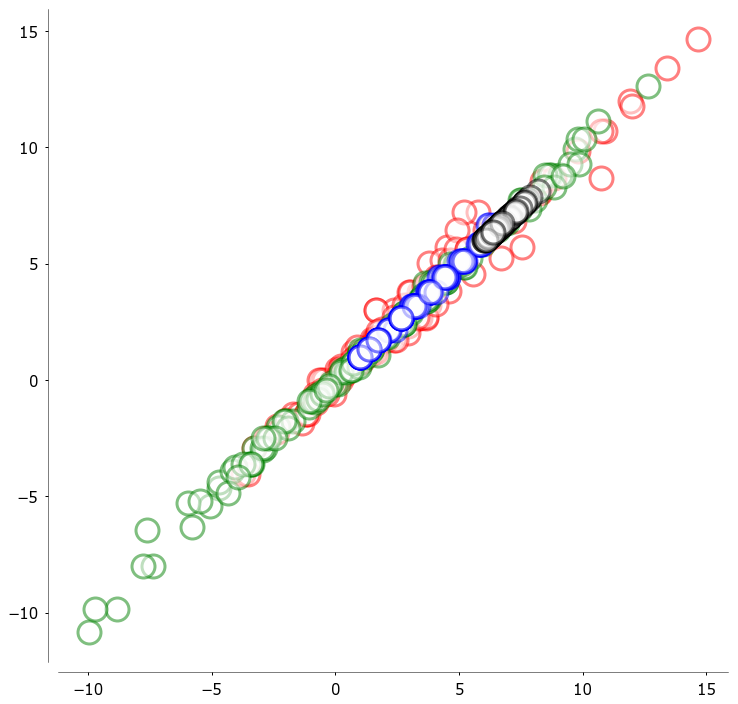

In [47]:
plt.figure(figsize=(12,12))

plt.plot(gf.iterative_search_params[gf.rsq_mask][:,0], 
         gf.gridsearch_params[gf.rsq_mask][:,0], 'wo', ms=23, mew=3, mec='r', alpha=0.5)
plt.plot(gf.iterative_search_params[gf.rsq_mask][:,1], 
         gf.gridsearch_params[gf.rsq_mask][:,1], 'wo', ms=23, mew=3, mec='g', alpha=0.5)
plt.plot(gf.iterative_search_params[gf.rsq_mask][:,2], 
         gf.gridsearch_params[gf.rsq_mask][:,2], 'wo', ms=23, mew=3, mec='b', alpha=0.5)
plt.plot(gf.iterative_search_params[gf.rsq_mask][:,-1]*10, 
         gf.gridsearch_params[gf.rsq_mask][:,-1]*10, 'wo', ms=23, mew=3, mec='k', alpha=0.5)

# plt.gca().set_xlim([0.5,0.83])
# plt.gca().set_ylim([0.5,0.83])
sns.despine(offset=10)


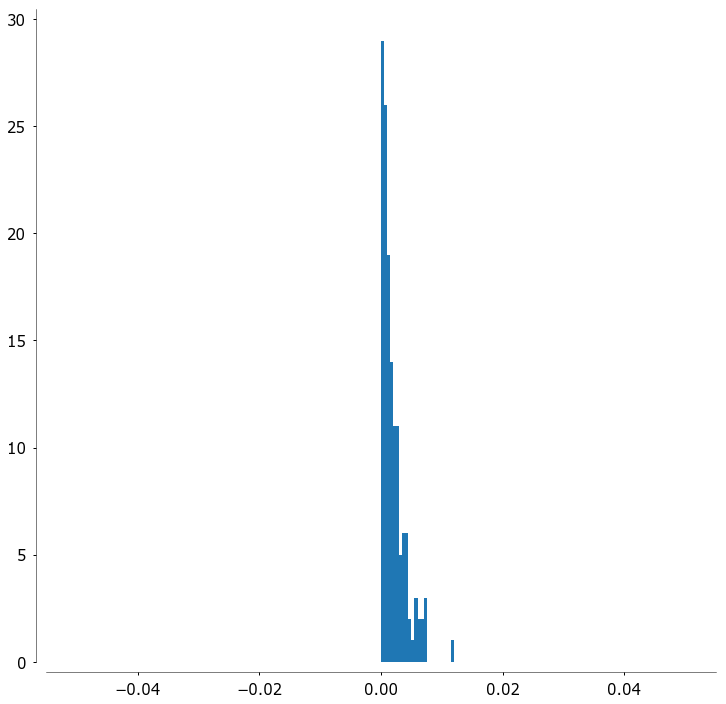

In [50]:
plt.figure(figsize=(12,12))
plt.hist(gf.iterative_search_params[gf.rsq_mask][:,-1] - gf.gridsearch_params[gf.rsq_mask][:,-1], 
         bins=200, range=[-0.05,0.05])
# plt.gca().set_xlim([0.5,0.83])
# plt.gca().set_ylim([0.5,0.83])
sns.despine(offset=10)



In [97]:
with open('grid_it.pkl', 'wb') as f:
    pickle.dump((gg, gf.iterative_search_params, gf.gridsearch_params), f)

In [22]:
with open('grid_it.pkl', 'rb') as f:
    gg, iterative_search_params, gridsearch_params = pickle.load(f)

## CNN tryouts

In [125]:
sequencer = cnn.Gaussian2D_isoCart_pRF_Sequence(n_timepoints=timecourse[mask].shape[-1], 
                                    batch_size=2048, 
                                    gridder=gg, 
                                    ecc_range=[0,12], 
                                    size_range=[0.1,15], 
                                    beta_range=[-0.05,0.06], 
                                    baseline_range=[-6,4], 
                                    n_range=[0.2,1], 
                                    grid_size=12, 
                                    drift_ranges=[[0, 0]], 
                                    noise_level=0, 
                                    noise_ar=(1,0.4))

vg = Iso2DGaussianGridder(stimulus=prf_stim)
validation_sequencer = cnn.Gaussian2D_isoCart_pRF_Sequence(n_timepoints=timecourse[mask].shape[-1], 
                                    batch_size=2048, 
                                    gridder=vg, 
                                    ecc_range=[0,12], 
                                    size_range=[0.1,15], 
                                    beta_range=[-0.05,0.06], 
                                    baseline_range=[-6,4], 
                                    n_range=[0.2,1], 
                                    grid_size=6, 
                                    drift_ranges=[[0, 0]], 
                                    noise_level=0, 
                                    noise_ar=(1,0.4))

In [148]:
cnn_model = cnn.create_cnn(n_timepoints=timecourse[mask].shape[-1], 
                           n_parameters=6, 
                           loss='mse', 
                           optimizer='nadam', 
                           metrics=['mae', 'mse'])
# serialize model to YAML
# model_yaml = cnn_model.to_yaml()
# with open(os.path.join(base_dir, 'data', 'model.yaml'), "w") as yaml_file:
#     yaml_file.write(model_yaml)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 164, 83)           415       
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 82, 83)            0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 79, 41)            13653     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 39, 41)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 34, 27)            6669      
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 11, 27)            0         
_________________________________________________________________
locally_connected1d_7 (Local (None, 4, 20)             17360     
__________

In [ ]:
noise_levels = [0.01, 0.1, 0.25, 0.5, 1.0, 2, 4]
f, ss = plt.subplots(1, len(noise_levels), figsize=(16,6), sharey=True)
histories = []
with tf.device('/gpu:0'):
    for i, noise_level in enumerate(noise_levels):
        sequencer.noise_level = noise_level
        history = cnn_model.fit_generator(generator=sequencer, 
                                  epochs=300, 
                                  verbose=0, 
                                  validation_data=validation_sequencer, 
                                  validation_steps=1, 
                                  class_weight=None, 
                                  max_queue_size=10, 
                                  workers=16, 
                                  use_multiprocessing=True, 
                                  shuffle=True, 
                                  initial_epoch=0)
        histories.append(pd.DataFrame(history.history))
        histories[-1].plot(logy=True, logx=True, figsize=(16,8), lw=3, ax=ss[i])

# serialize weights to HDF5
# cnn_model.save_weights(os.path.join(os.getcwd().split()[0], 'data', 'cnn_model.h5'))

In [168]:
%%time
cnn_output_pars = cnn_model.predict(timecourse[mask][:,:,np.newaxis])

CPU times: user 8.41 s, sys: 828 ms, total: 9.24 s
Wall time: 6.51 s


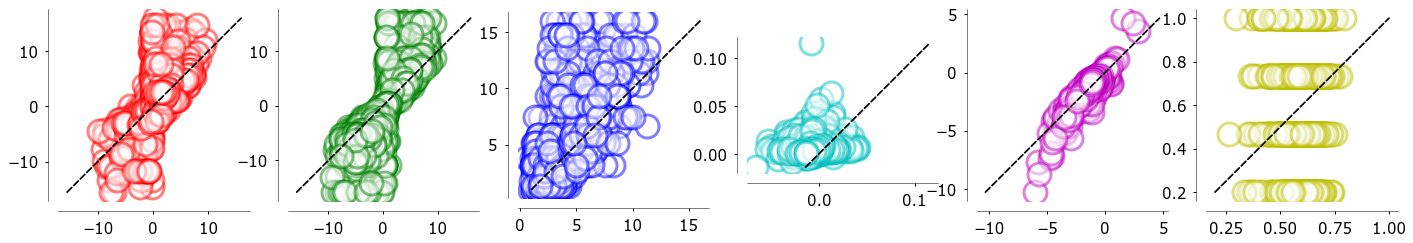

In [171]:
n_pars = 6
colors = ['r','g','b','c','m','y']
rsq_mask = gridsearch_params[:,-1] > 0.4

cnn_xys = cnn_output_pars[rsq_mask,0:n_pars]
grid_xys = gridsearch_params[rsq_mask,0:n_pars]

f, ss = plt.subplots(1,n_pars, figsize=(24,7))
for i, s, c in zip(range(n_pars), ss, colors[:n_pars]):
    s.plot(cnn_xys[:,i], 
         grid_xys[:,i], 'wo', ms=23, mew=3, mec=c, alpha=0.5)
    s.plot([np.min(grid_xys[:,i]), np.max(grid_xys[:,i])],[np.min(grid_xys[:,i]), np.max(grid_xys[:,i])], 'k--')
    s.set_aspect(1)
sns.despine(offset=10)

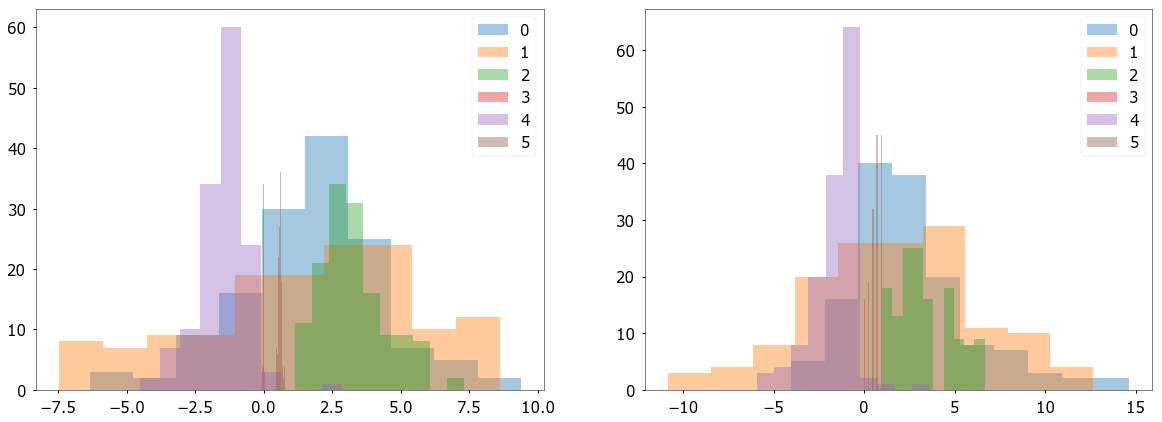

In [165]:
f, ss = plt.subplots(1,2, figsize=(20,7))
for i in range(cnn_output_pars.shape[-1]):
    ss[0].hist(cnn_output_pars[rsq_mask,i], label=str(i), alpha=0.4)
ss[0].legend()

for i in range(cnn_output_pars.shape[-1]):
    ss[1].hist(gridsearch_params[rsq_mask,i], label=str(i), alpha=0.4)
ss[1].legend()

In [166]:
max_voxel = gridsearch_params[:,-1].argmax()
print(cnn_output_pars[max_voxel])
print(gridsearch_params[max_voxel])

[ 3.6725345   8.277444    3.8578968  -0.02442428 -2.9154592   0.54601985]
[ 6.45614125e+00  8.29485045e+00  6.65096953e+00  7.32860700e-03
 -3.10393574e+00  1.00000000e+00  8.14043294e-01]


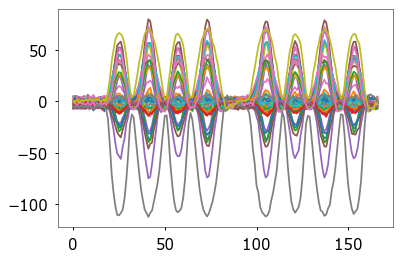

In [142]:
# 
plt.plot(sequencer.predictions[1:50,:,0].T);

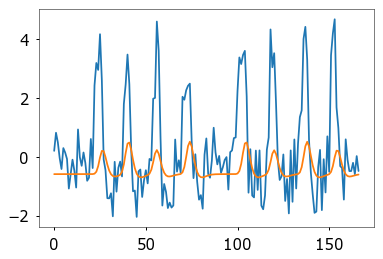

In [147]:
plt.plot(timecourse[mask][max_voxel+3,:])
plt.plot(gg.return_single_prediction(*cnn_output_pars[max_voxel+3]).T)
